In [324]:
import warnings
warnings.filterwarnings('ignore')
from pre_process import preprocess_
from imputation import imputer
import seaborn as sns
import feature_extraction
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import periodogram
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, StratifiedKFold
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import accuracy_score, recall_score , precision_score, confusion_matrix
import xgboost as xgb
from cf_matrix import make_confusion_matrix


from sklearn.utils.class_weight import compute_sample_weight
from sklearn.preprocessing import LabelEncoder

In [2]:
pre_obj=preprocess_('/home/qb/ML_Group_Assignment/weather/', cleaning=True )
#read the weather data into the out folders
pre_obj.read_data(type_ = 'weather')
#create the dates and the co-ordinates using the same object
pre_obj._clean_(type_='weather')

In [3]:
misc_obj = preprocess_('/home/qb/ML_Group_Assignment/', cleaning=True)
misc_obj.read_data(type_='misc')

In [4]:
train_ = preprocess_('/home/qb/ML_Group_Assignment/sub_stations', cleaning=True)
train_.read_data(type_='train')
train_._clean_(type_='train')

In [5]:
#pefrom imputation before the split because this is pre defined method
imp_=imputer(pre_obj, train_)
imp_._impute_substation(method='Tiwari')
imp_._impute_substation(method='ema')

In [6]:
l = pd.read_csv(train_.path+'/df.csv')
# l.drop(columns = ['Unnamed: 0.3'], inplace=True )

<Axes: >

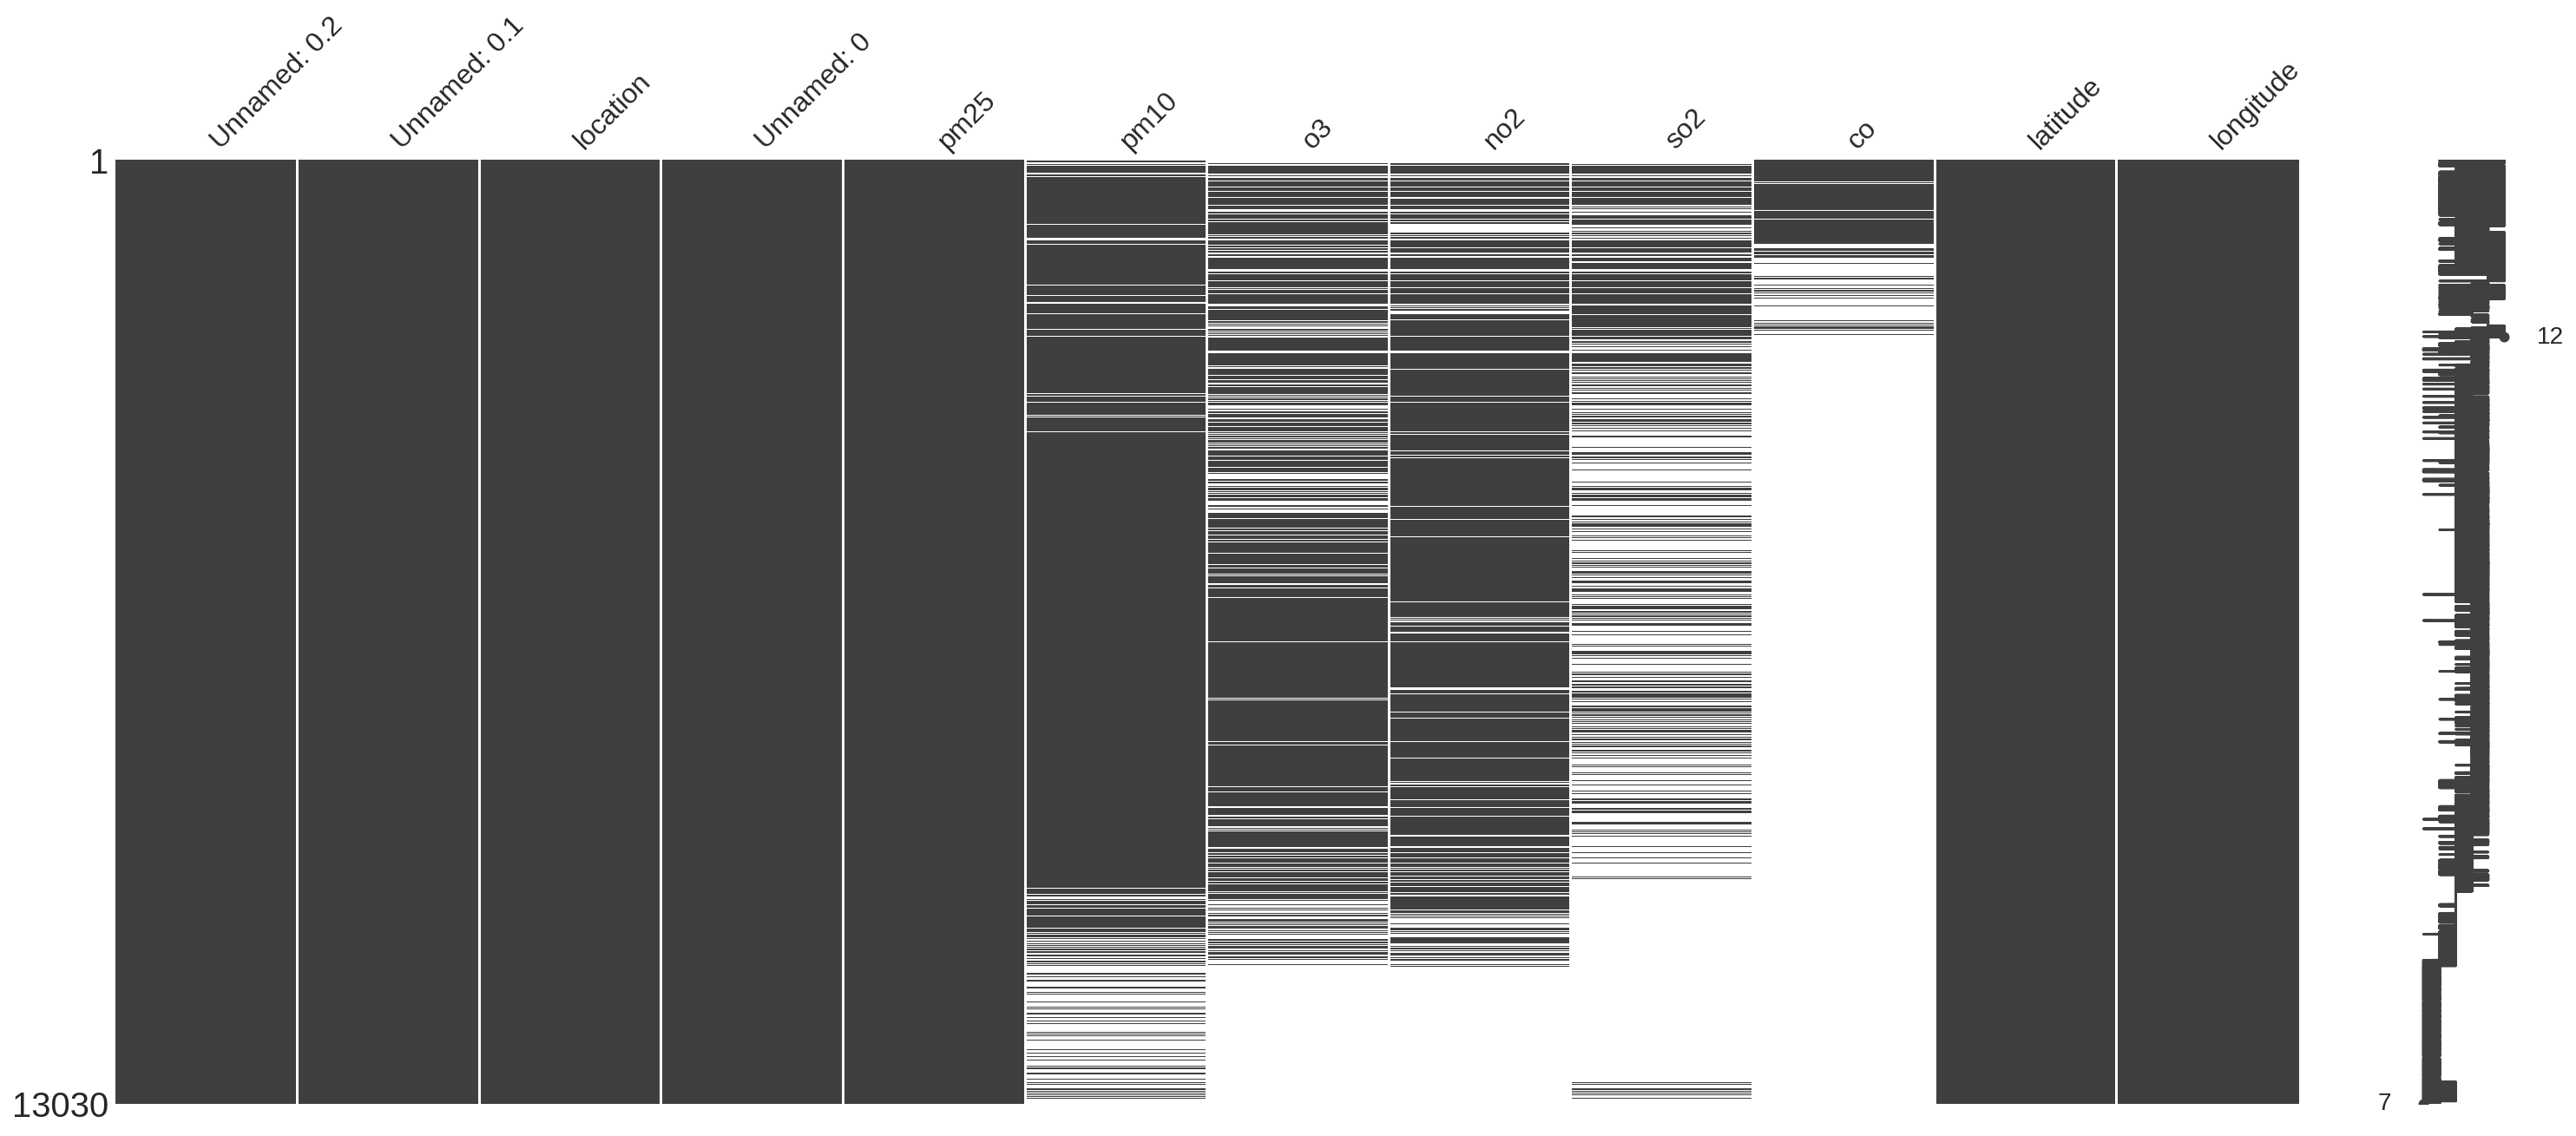

In [190]:
import missingno
missingno.matrix(l)

**Still left with missing columns we will for not train models that can handel those missing values and later as time goes will try to fill them**

In [20]:
#
# plt.scatter(l['pm25'],l['pm25'].shift(1))

In [26]:
# l['date']=pd.to_datetime(l['date'])
# l.set_index('date', inplace=True)
y = l.to_period('M')
df = pd.DataFrame({
    'y': y['pm25'],
    'y_lag_1': y['pm25'].shift(1),
    'y_lag_2': y['pm25'].shift(2), 
    'y_lag_3': y['pm25'].shift(3),
    'y_lag_4': y['pm25'].shift(4),    

})

df.head()

,y,y_lag_1,y_lag_2,y_lag_3,y_lag_4
date,,,,,
2024-10,72.0,NaN,NaN,NaN,NaN
2024-10,65.0,72.0,NaN,NaN,NaN
2024-10,70.0,65.0,72.0,NaN,NaN
2024-10,70.0,70.0,65.0,72.0,NaN
2024-10,93.0,70.0,70.0,65.0,72.0


<Axes: xlabel='y', ylabel='y_lag_2'>

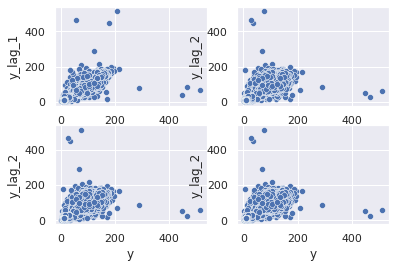

In [27]:
import seaborn as sns
sns.set_theme()
fig,ax=plt.subplots(2,2)
ax = ax.flatten()
sns.scatterplot(data = df.reset_index(), x = 'y', y='y_lag_1', ax = ax[0])
sns.scatterplot(data = df.reset_index(), x ='y' , y ='y_lag_2', ax = ax[1])
sns.scatterplot(data = df.reset_index(), x ='y' , y ='y_lag_2', ax = ax[2])
sns.scatterplot(data = df.reset_index(), x ='y' , y ='y_lag_2', ax = ax[3])


**The pm25 Monthly lags values does have much larger lags infact only one month is showing as the lag increase the pm25 values becomes irrelevant, lets try to do some modeling and lag analysis**

In [111]:
from scipy.signal import periodogram
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.preprocessing import OneHotEncoder

In [29]:
# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 4))
plt.rc("axes",labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
)
%config InlineBackend.figure_format = 'retina'

In [30]:
def lagplot(x, y=None, lag=1, standardize=False, ax=None, **kwargs):
    from matplotlib.offsetbox import AnchoredText
    x_ = x.shift(lag)
    if standardize:
        x_ = (x_ - x_.mean()) / x_.std()
    if y is not None:
        y_ = (y - y.mean()) / y.std() if standardize else y
    else:
        y_ = x
    corr = y_.corr(x_)
    if ax is None:
        fig, ax = plt.subplots()
    scatter_kws = dict(
        alpha=0.75,
        s=3,
    )
    line_kws = dict(color='C3', )
    ax = sns.regplot(x=x_,
                     y=y_,
                     scatter_kws=scatter_kws,
                     line_kws=line_kws,
                     lowess=True,
                     ax=ax,
                     **kwargs)
    at = AnchoredText(
        f"{corr:.2f}",
        prop=dict(size="large"),
        frameon=True,
        loc="upper left",
    )
    at.patch.set_boxstyle("square, pad=0.0")
    ax.add_artist(at)
    ax.set(title=f"Lag {lag}", xlabel=x_.name, ylabel=y_.name)
    return ax

In [32]:
def plot_lags(x, y=None, lags=6, nrows=1, lagplot_kwargs={}, **kwargs):
    import math
    kwargs.setdefault('nrows', nrows)
    kwargs.setdefault('ncols', math.ceil(lags / nrows))
    kwargs.setdefault('figsize', (kwargs['ncols'] * 2, nrows * 2 + 0.5))
    fig, axs = plt.subplots(sharex=True, sharey=True, squeeze=False, **kwargs)
    for ax, k in zip(fig.get_axes(), range(kwargs['nrows'] * kwargs['ncols'])):
        if k + 1 <= lags:
            ax = lagplot(x, y, lag=k + 1, ax=ax, **lagplot_kwargs)
            ax.set_title(f"Lag {k + 1}", fontdict=dict(fontsize=14))
            ax.set(xlabel="", ylabel="")
        else:
            ax.axis('off')
    plt.setp(axs[-1, :], xlabel=x.name)
    plt.setp(axs[:, 0], ylabel=y.name if y is not None else x.name)
    fig.tight_layout(w_pad=0.1, h_pad=0.1)
    return fig

In [35]:
l.reset_index(inplace=True)

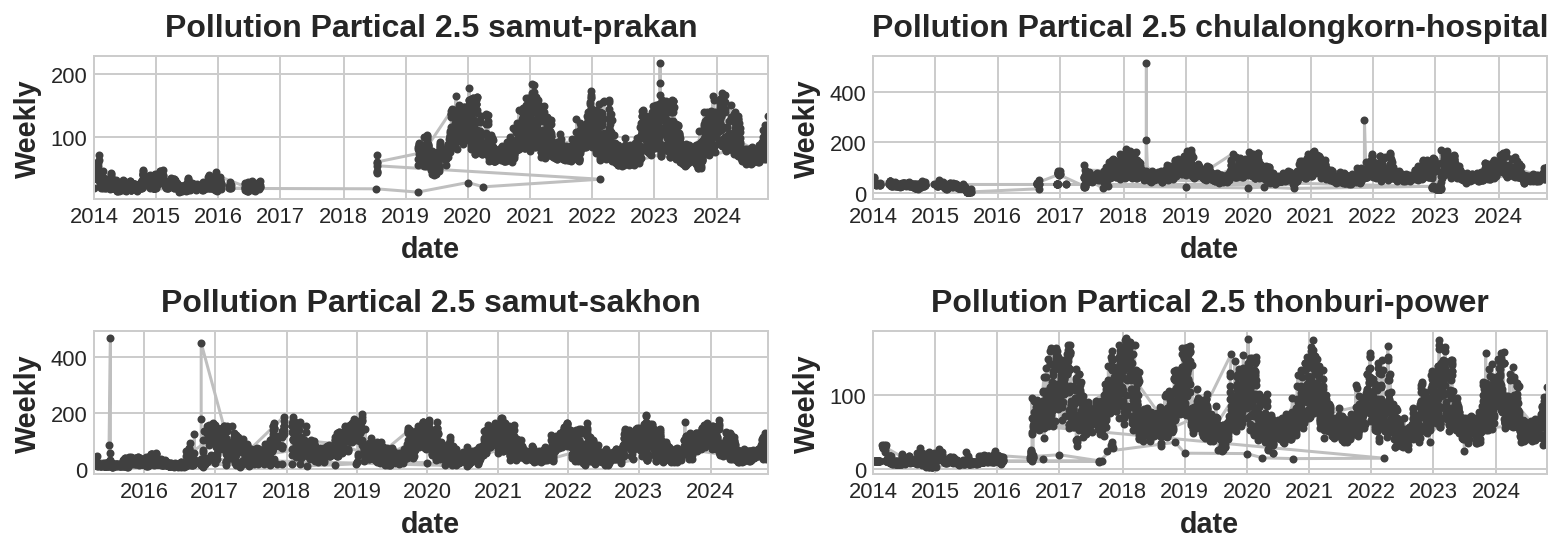

In [45]:
l.set_index(
    pd.PeriodIndex(l.date, freq="W"),
    inplace=True,
)
# l.drop("week", axis=1, inplace=True)
fig,axs=plt.subplots(2,2)
axs = axs.flatten()
locations = l.location.unique()
for i,a in enumerate(axs):
    l_ = l[l['location'] == locations[i]]
    ax = l_.pm25.plot(title=f'Pollution Partical 2.5 {locations[i]}', **plot_params, ax=a)
    _ = ax.set(ylabel="Weekly")
plt.tight_layout()

In [128]:
l.sort_index(inplace=True)

**we have couple of outliers hanging on**

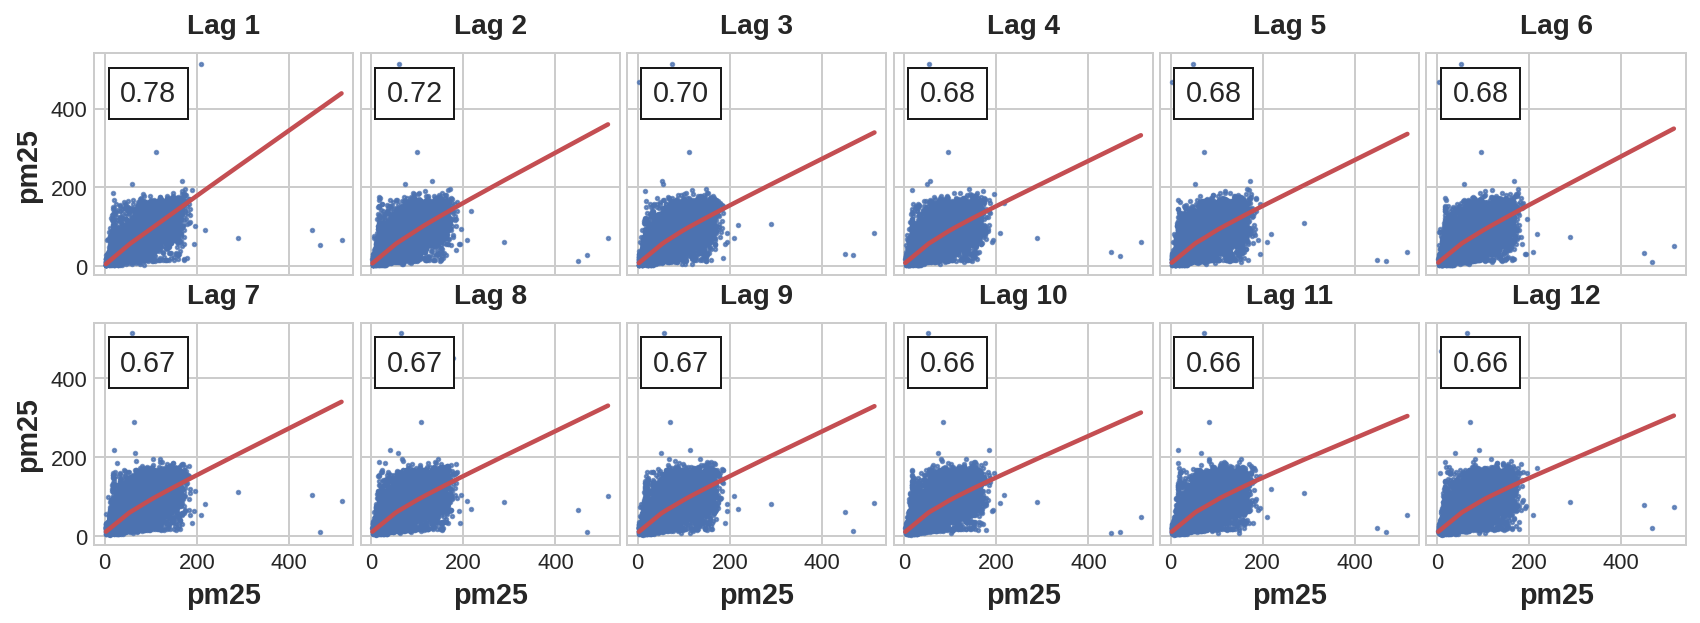

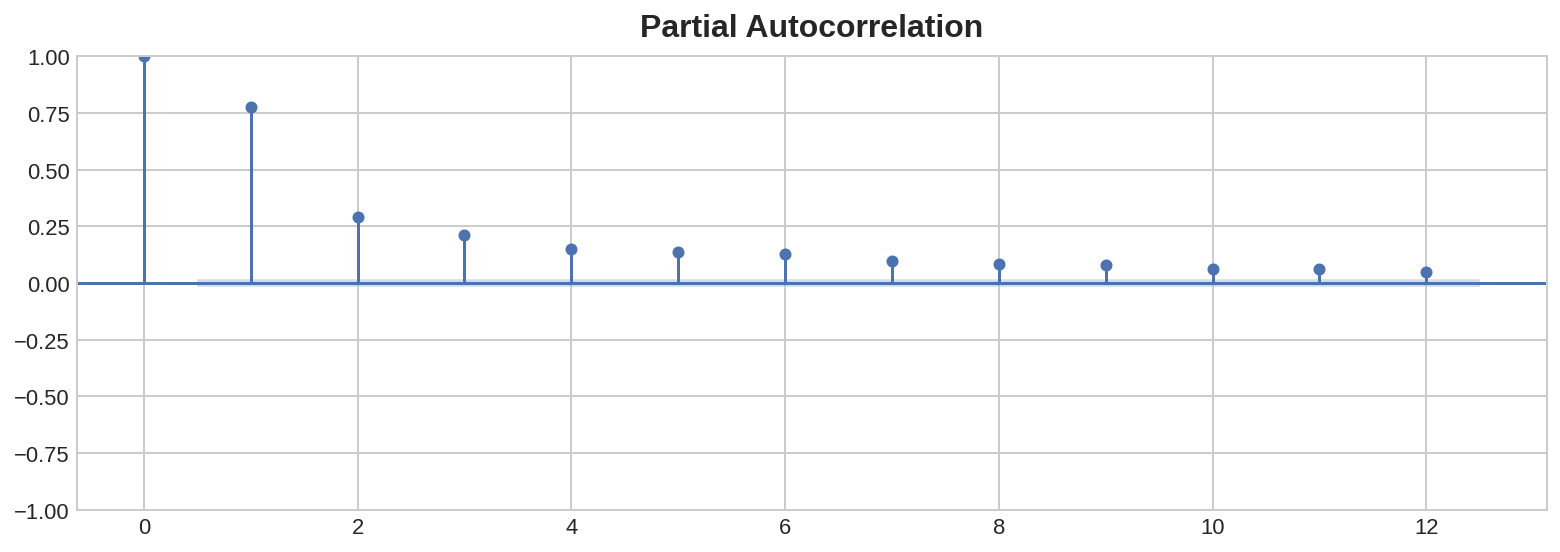

In [129]:
_ = plot_lags(l.pm25, lags=12, nrows=2)
_ = plot_pacf(l.pm25, lags=12)

In [130]:
def make_lags(ts, lags):
    return pd.concat(
        {
            f'y_lag_{i}': ts.shift(i)
            for i in range(1, lags + 1)
        },
        axis=1)


X = make_lags(l.pm25, lags=7)
X = X.fillna(0.0)
X['locations'] = l['location']
X=X.sort_index()

In [131]:
# y = l.pm25.copy()
X_train = []
X_test = []
Y_train = []
Y_test = []
for loc in locations:
    x_ = X[X['locations'] == loc]
    y = l[l['location'] == loc].pm25.copy()
    x_train, x_test, y_train, y_test = train_test_split(x_, y, test_size=60, shuffle=False)
    X_train.append(x_train)
    X_test.append(x_test)
    Y_train.append(y_train)
    Y_test.append(y_test)
    

X_train = pd.concat(X_train)
X_test = pd.concat(X_test)
y_train = pd.concat(Y_train)
y_test = pd.concat(Y_test)

ohe = OneHotEncoder()
om=ohe.fit(X_train['locations'].values.reshape(-1,1))
X_train[locations]=om.transform(X_train['locations'].values.reshape(-1,1)).toarray()
X_test[locations]=om.transform(X_test['locations'].values.reshape(-1,1)).toarray()

In [132]:
X_test.drop(columns ={'locations'}, inplace=True)
X_train.drop(columns = {'locations'}, inplace=True)

In [133]:
# Fit and predict
model = LinearRegression()  # `fit_intercept=True` since we didn't use DeterministicProcess
model.fit(X_train, y_train)
y_pred = pd.Series(model.predict(X_train), index=y_train.index)
y_fore = pd.Series(model.predict(X_test), index=y_test.index)

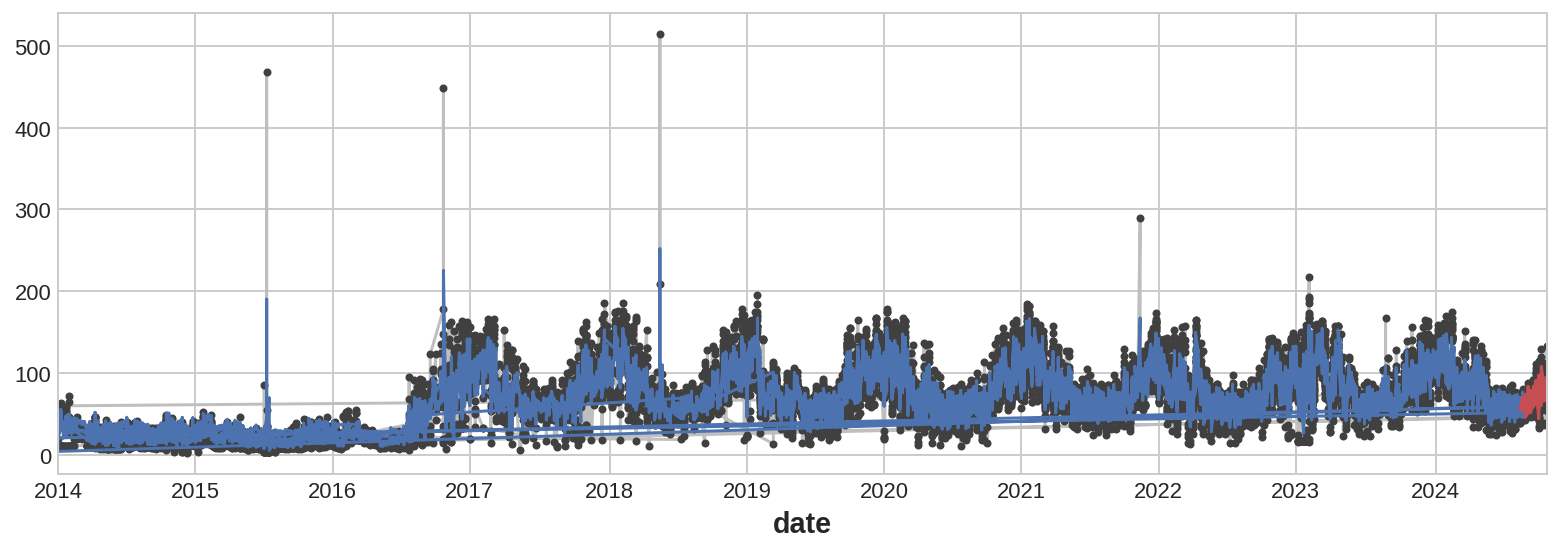

In [134]:
ax = y_train.plot(**plot_params)
ax = y_test.plot(**plot_params)
ax = y_pred.plot(ax=ax)
_ = y_fore.plot(ax=ax, color='C3')

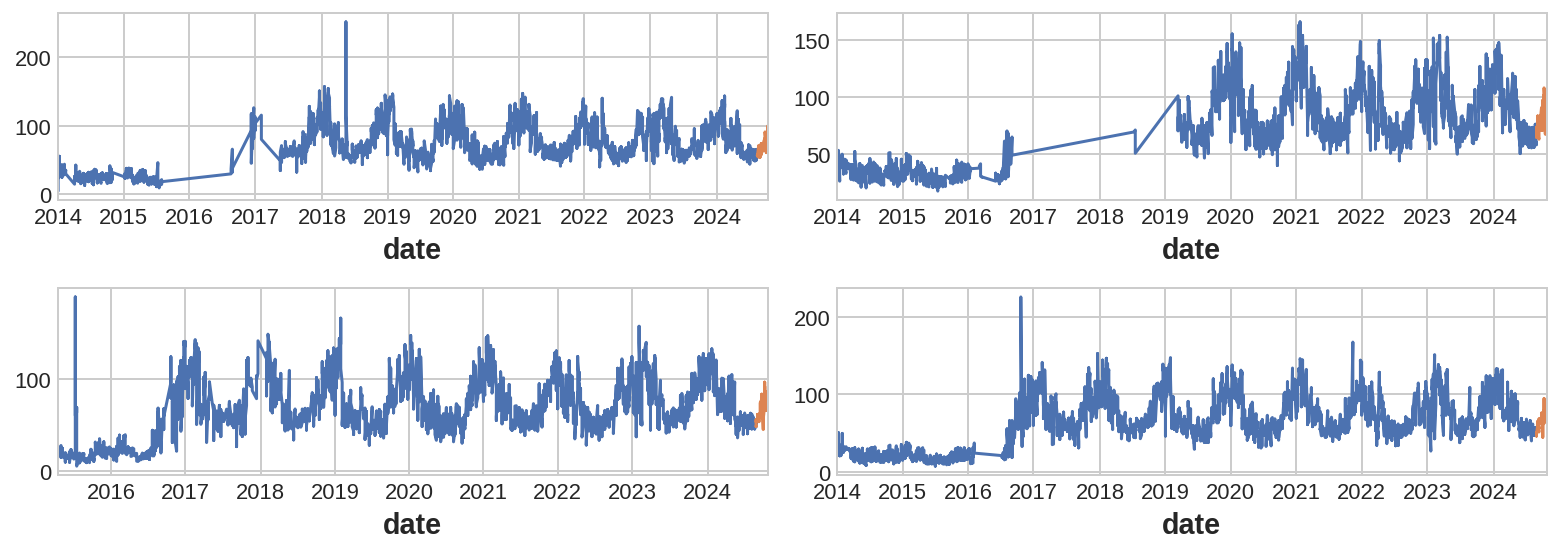

In [135]:
#just to create predictions
fig,axs=plt.subplots(2,2)
axs = axs.flatten()

for i,a in enumerate(axs):
    x_=X_train[X_train[locations[i]] == 1.0]
#     x_.drop(columns = {'locations'}, inplace=True)
    ax = pd.Series(model.predict(x_), index=x_.index).plot(ax=a)
    _x_= X_test[X_test[locations[i]] == 1.0] 
    pd.Series(model.predict(_x_), index = _x_.index).plot(ax=a)
plt.tight_layout()

In [136]:
#performing xgboosting modeling

,y_lag_1,y_lag_2,y_lag_3,y_lag_4,y_lag_5,y_lag_6,y_lag_7,locations
date,,,,,,,,
2013-12-30/2014-01-05,0.000000,0.000000,0.000000,0.00,0.0,0.0,0.0,chulalongkorn-hospital
2013-12-30/2014-01-05,59.820000,0.000000,0.000000,0.00,0.0,0.0,0.0,chulalongkorn-hospital
2013-12-30/2014-01-05,33.242321,59.820000,0.000000,0.00,0.0,0.0,0.0,thonburi-power
2013-12-30/2014-01-05,10.692570,33.242321,59.820000,0.00,0.0,0.0,0.0,chulalongkorn-hospital
2013-12-30/2014-01-05,33.242321,10.692570,33.242321,59.82,0.0,0.0,0.0,samut-prakan
...,...,...,...,...,...,...,...,...
2024-10-21/2024-10-27,81.000000,60.000000,53.000000,64.00,61.0,97.0,82.0,samut-sakhon
2024-10-21/2024-10-27,68.000000,81.000000,60.000000,53.00,64.0,61.0,97.0,samut-sakhon
2024-10-21/2024-10-27,112.000000,68.000000,81.000000,60.00,53.0,64.0,61.0,samut-sakhon


<Axes: xlabel='date'>

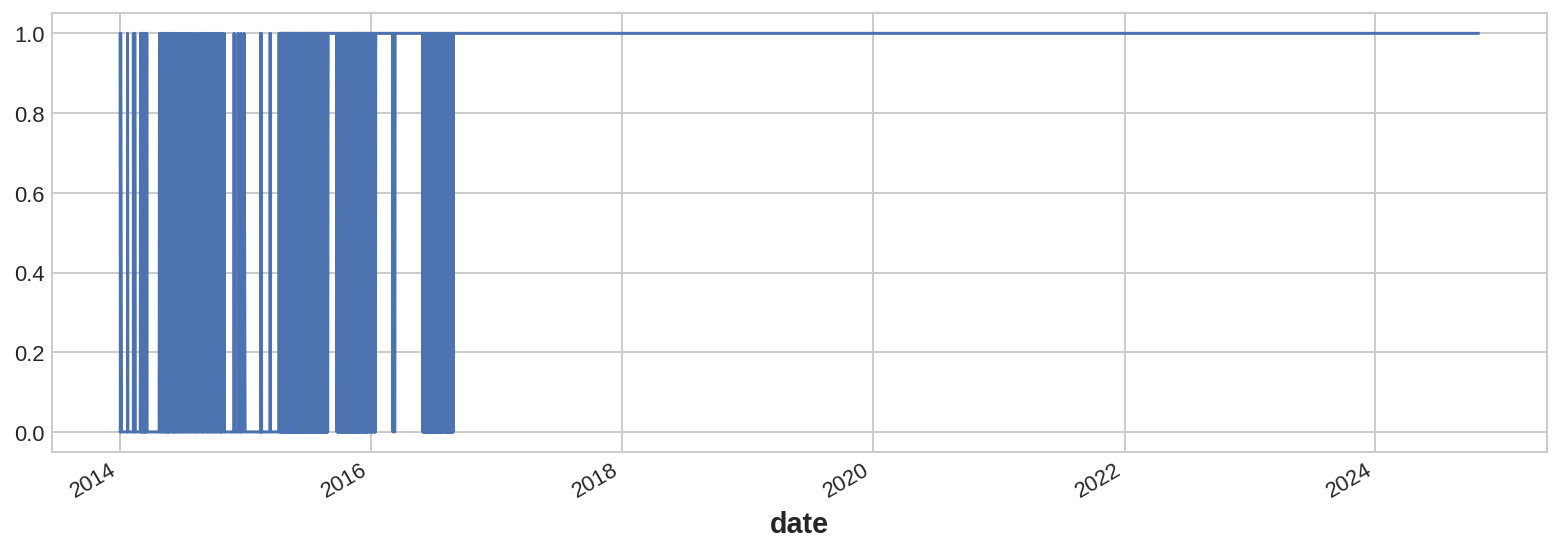

In [172]:
# l[l['co'].isna()]['pm25'].hist()
# # l[~(l['co'].isna())]['pm25'].hist()

# l['date']=pd.to_datetime(l['date'])
# l.set_index('date', inplace=True)
# l.sort_index(inplace=True)

(l['co'].isna()*1).plot()

**This is the serious concern i have been raising it again and again that where pm2.5 is lower we have co but where it is ranging we dont , but more over it is clear now that the missingness is not more that certain time period so it is considered missing not at random with the data we have**

<Axes: >

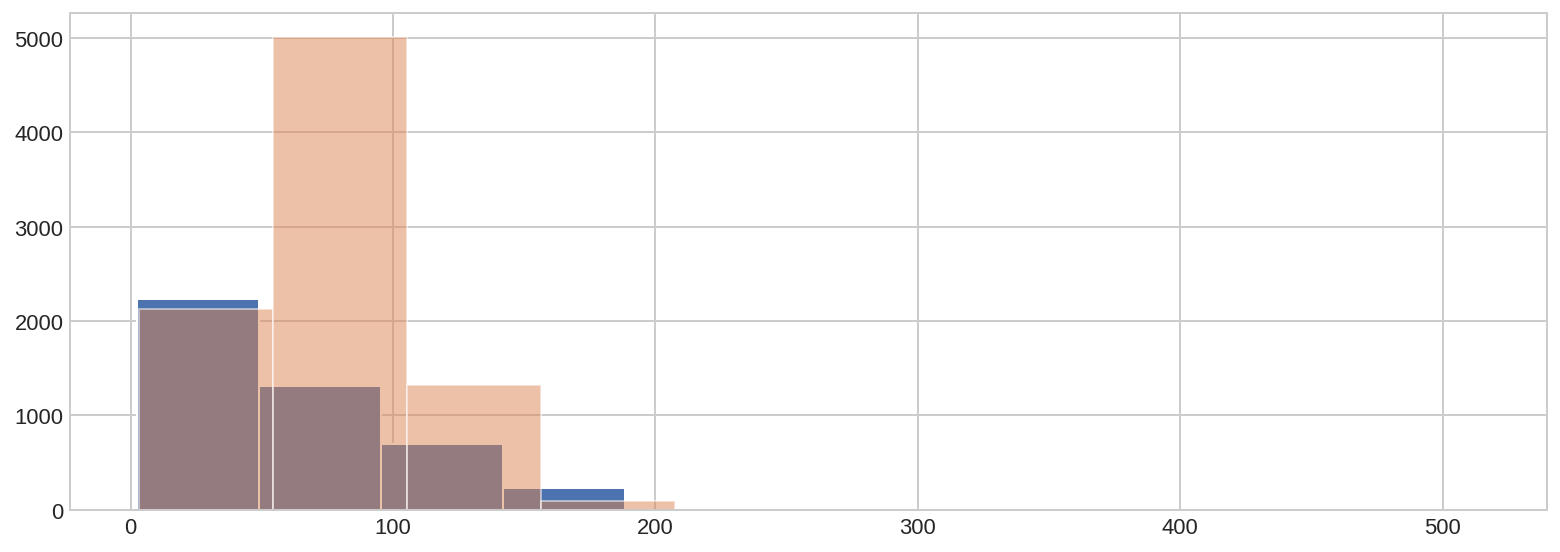

In [189]:
l[~(l['so2'].isna())]['pm25'].hist()
l[(l['so2'].isna())]['pm25'].hist(alpha=0.5)

**This is interesting pattren could be coming from sensors whenever pm2.5 goes down so2 is missing we will use knn imputer or iterative imputation method to impute these vlaues**

<Axes: xlabel='date'>

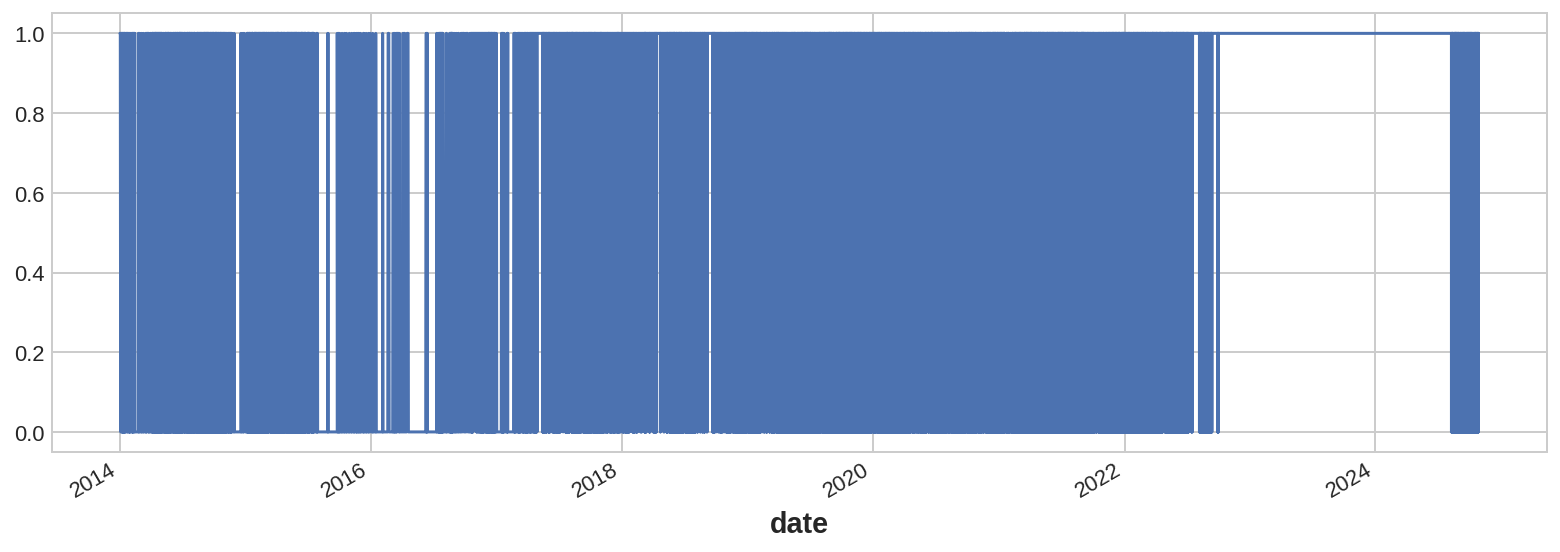

In [194]:
(l['so2'].isna()*1).plot()

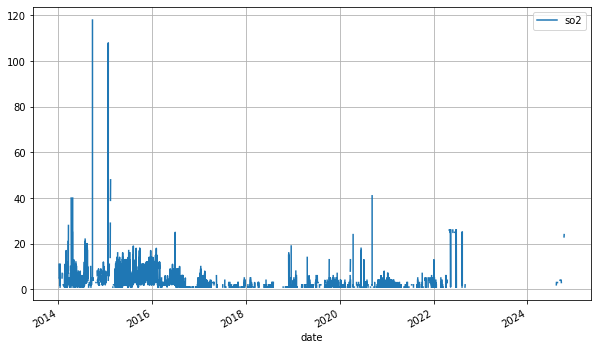

In [22]:
l['date']=pd.to_datetime(l['date'])
plt.figure(figsize=(10, 6))
l.set_index('date')['so2'][::-1].plot()
plt.legend()
plt.grid(True)

In [5]:
filled_data, forcaste_with_confidence=imp_.prohet_imputer(name='so2')

Data with missing values:
          ds   y
0 2024-10-01 NaN
1 2024-10-02 NaN
2 2024-10-03 NaN
3 2024-10-04 NaN
4 2024-10-05 NaN
5 2024-10-06 NaN
6 2024-10-07 NaN
7 2024-10-08 NaN
8 2024-10-09 NaN
9 2024-10-10 NaN
Found 8559 missing values in 'y' column.


20:41:32 - cmdstanpy - INFO - Chain [1] start processing
20:41:33 - cmdstanpy - INFO - Chain [1] done processing


Forecast structure (first few rows):
          ds      yhat  yhat_lower  yhat_upper
0 2014-01-03  6.030307   -1.091108   13.298452
1 2014-01-06  6.104713   -1.190793   13.039152
2 2014-01-07  5.939427   -0.849289   12.582786
3 2014-01-08  6.300785   -0.897033   13.232256
4 2014-01-09  6.082692   -0.932573   12.897853
Processing missing value for index 5958
Processing missing value for index 5873
Processing missing value for index 13001
Processing missing value for index 5874
Processing missing value for index 5959
Processing missing value for index 5875
Processing missing value for index 13002
Processing missing value for index 5876
Processing missing value for index 5877
Processing missing value for index 5878
Processing missing value for index 13003
Processing missing value for index 5879
Processing missing value for index 13004
Processing missing value for index 5880
Processing missing value for index 5881
Processing missing value for index 5882
Processing missing value for index 58

Processing missing value for index 5738
Processing missing value for index 12701
Processing missing value for index 5739
Processing missing value for index 12702
Processing missing value for index 12703
Processing missing value for index 5740
Processing missing value for index 5741
Processing missing value for index 12704
Processing missing value for index 12705
Processing missing value for index 5919
Processing missing value for index 12706
Processing missing value for index 5742
Processing missing value for index 12707
Processing missing value for index 12708
Processing missing value for index 5743
Processing missing value for index 12709
Processing missing value for index 5744
Processing missing value for index 12710
Processing missing value for index 5745
Processing missing value for index 5746
Processing missing value for index 12711
Processing missing value for index 12712
Processing missing value for index 5920
Processing missing value for index 12976
Processing missing value fo

Processing missing value for index 12679
Processing missing value for index 5726
Processing missing value for index 5727
Processing missing value for index 12680
Processing missing value for index 5728
Processing missing value for index 5910
Processing missing value for index 5911
Processing missing value for index 12684
Processing missing value for index 5912
Processing missing value for index 5913
Processing missing value for index 5914
Processing missing value for index 5915
Processing missing value for index 5916
Processing missing value for index 5917
Processing missing value for index 5729
Processing missing value for index 5730
Processing missing value for index 5731
Processing missing value for index 5732
Processing missing value for index 5733
Processing missing value for index 5590
Processing missing value for index 5591
Processing missing value for index 5592
Processing missing value for index 5593
Processing missing value for index 5594
Processing missing value for index 55

Processing missing value for index 8801
Processing missing value for index 8802
Processing missing value for index 9238
Processing missing value for index 12300
Processing missing value for index 9239
Processing missing value for index 9240
Processing missing value for index 9241
Processing missing value for index 12302
Processing missing value for index 12303
Processing missing value for index 8808
Processing missing value for index 12217
Processing missing value for index 5904
Processing missing value for index 5563
Processing missing value for index 5564
Processing missing value for index 5565
Processing missing value for index 5566
Processing missing value for index 5567
Processing missing value for index 5568
Processing missing value for index 5569
Processing missing value for index 5570
Processing missing value for index 9279
Processing missing value for index 8819
Processing missing value for index 2121
Processing missing value for index 12245
Processing missing value for index 

Processing missing value for index 11950
Processing missing value for index 8524
Processing missing value for index 11951
Processing missing value for index 11952
Processing missing value for index 11953
Processing missing value for index 8527
Processing missing value for index 11954
Processing missing value for index 11955
Processing missing value for index 11956
Processing missing value for index 11957
Processing missing value for index 11958
Processing missing value for index 11959
Processing missing value for index 11960
Processing missing value for index 11961
Processing missing value for index 11962
Processing missing value for index 11963
Processing missing value for index 8537
Processing missing value for index 11964
Processing missing value for index 11965
Processing missing value for index 11966
Processing missing value for index 11967
Processing missing value for index 11968
Processing missing value for index 11969
Processing missing value for index 11970
Processing missing 

Processing missing value for index 11884
Processing missing value for index 5427
Processing missing value for index 5428
Processing missing value for index 11885
Processing missing value for index 5429
Processing missing value for index 11886
Processing missing value for index 5430
Processing missing value for index 11887
Processing missing value for index 5431
Processing missing value for index 11888
Processing missing value for index 5432
Processing missing value for index 11889
Processing missing value for index 11890
Processing missing value for index 8464
Processing missing value for index 5433
Processing missing value for index 11891
Processing missing value for index 5434
Processing missing value for index 5435
Processing missing value for index 11892
Processing missing value for index 5436
Processing missing value for index 11893
Processing missing value for index 5437
Processing missing value for index 11894
Processing missing value for index 11895
Processing missing value for

Processing missing value for index 5377
Processing missing value for index 5378
Processing missing value for index 5379
Processing missing value for index 5380
Processing missing value for index 5381
Processing missing value for index 5382
Processing missing value for index 8439
Processing missing value for index 5383
Processing missing value for index 5384
Processing missing value for index 5385
Processing missing value for index 5386
Processing missing value for index 11843
Processing missing value for index 5387
Processing missing value for index 11844
Processing missing value for index 5388
Processing missing value for index 5389
Processing missing value for index 11846
Processing missing value for index 11847
Processing missing value for index 5390
Processing missing value for index 5210
Processing missing value for index 11672
Processing missing value for index 5211
Processing missing value for index 5212
Processing missing value for index 5213
Processing missing value for index 

Processing missing value for index 8274
Processing missing value for index 8275
Processing missing value for index 5148
Processing missing value for index 11610
Processing missing value for index 5149
Processing missing value for index 11611
Processing missing value for index 8276
Processing missing value for index 5150
Processing missing value for index 11612
Processing missing value for index 11613
Processing missing value for index 5151
Processing missing value for index 5152
Processing missing value for index 8279
Processing missing value for index 11614
Processing missing value for index 8280
Processing missing value for index 11615
Processing missing value for index 5153
Processing missing value for index 8281
Processing missing value for index 11616
Processing missing value for index 5154
Processing missing value for index 11617
Processing missing value for index 5155
Processing missing value for index 8282
Processing missing value for index 8283
Processing missing value for ind

Processing missing value for index 8230
Processing missing value for index 5086
Processing missing value for index 5087
Processing missing value for index 8231
Processing missing value for index 11549
Processing missing value for index 8232
Processing missing value for index 11550
Processing missing value for index 5088
Processing missing value for index 11551
Processing missing value for index 8233
Processing missing value for index 5089
Processing missing value for index 5090
Processing missing value for index 11552
Processing missing value for index 5091
Processing missing value for index 11553
Processing missing value for index 5092
Processing missing value for index 5093
Processing missing value for index 5094
Processing missing value for index 11556
Processing missing value for index 5095
Processing missing value for index 11557
Processing missing value for index 5096
Processing missing value for index 11558
Processing missing value for index 11559
Processing missing value for in

Processing missing value for index 4992
Processing missing value for index 8139
Processing missing value for index 4993
Processing missing value for index 4994
Processing missing value for index 8140
Processing missing value for index 4995
Processing missing value for index 4996
Processing missing value for index 4997
Processing missing value for index 4998
Processing missing value for index 4999
Processing missing value for index 5000
Processing missing value for index 8146
Processing missing value for index 5001
Processing missing value for index 5002
Processing missing value for index 5003
Processing missing value for index 5004
Processing missing value for index 11466
Processing missing value for index 5005
Processing missing value for index 5006
Processing missing value for index 5007
Processing missing value for index 5008
Processing missing value for index 8155
Processing missing value for index 5009
Processing missing value for index 5010
Processing missing value for index 8156

Processing missing value for index 4763
Processing missing value for index 11226
Processing missing value for index 1948
Processing missing value for index 4764
Processing missing value for index 1949
Processing missing value for index 11227
Processing missing value for index 1950
Processing missing value for index 11228
Processing missing value for index 4765
Processing missing value for index 4766
Processing missing value for index 11229
Processing missing value for index 1952
Processing missing value for index 11230
Processing missing value for index 4767
Processing missing value for index 4768
Processing missing value for index 11231
Processing missing value for index 1953
Processing missing value for index 4769
Processing missing value for index 11232
Processing missing value for index 11233
Processing missing value for index 4770
Processing missing value for index 4771
Processing missing value for index 1956
Processing missing value for index 11234
Processing missing value for in

Processing missing value for index 7829
Processing missing value for index 11138
Processing missing value for index 4676
Processing missing value for index 11139
Processing missing value for index 4677
Processing missing value for index 11140
Processing missing value for index 1862
Processing missing value for index 11141
Processing missing value for index 1863
Processing missing value for index 4678
Processing missing value for index 1864
Processing missing value for index 11142
Processing missing value for index 4679
Processing missing value for index 1865
Processing missing value for index 11143
Processing missing value for index 4680
Processing missing value for index 1866
Processing missing value for index 11144
Processing missing value for index 4681
Processing missing value for index 11145
Processing missing value for index 1867
Processing missing value for index 4682
Processing missing value for index 11146
Processing missing value for index 4683
Processing missing value for in

Processing missing value for index 11214
Processing missing value for index 4752
Processing missing value for index 11215
Processing missing value for index 4753
Processing missing value for index 11216
Processing missing value for index 4754
Processing missing value for index 1939
Processing missing value for index 11217
Processing missing value for index 11036
Processing missing value for index 7727
Processing missing value for index 4573
Processing missing value for index 1758
Processing missing value for index 11037
Processing missing value for index 4574
Processing missing value for index 11038
Processing missing value for index 4575
Processing missing value for index 4576
Processing missing value for index 11039
Processing missing value for index 11040
Processing missing value for index 4577
Processing missing value for index 11041
Processing missing value for index 4578
Processing missing value for index 11042
Processing missing value for index 4579
Processing missing value for 

Processing missing value for index 4492
Processing missing value for index 4493
Processing missing value for index 10956
Processing missing value for index 1678
Processing missing value for index 7648
Processing missing value for index 4494
Processing missing value for index 10957
Processing missing value for index 1679
Processing missing value for index 10958
Processing missing value for index 1680
Processing missing value for index 4495
Processing missing value for index 10959
Processing missing value for index 1681
Processing missing value for index 4496
Processing missing value for index 10960
Processing missing value for index 4497
Processing missing value for index 1682
Processing missing value for index 1683
Processing missing value for index 4498
Processing missing value for index 10961
Processing missing value for index 1684
Processing missing value for index 4499
Processing missing value for index 10962
Processing missing value for index 10963
Processing missing value for ind

Processing missing value for index 10866
Processing missing value for index 1589
Processing missing value for index 10867
Processing missing value for index 10868
Processing missing value for index 4405
Processing missing value for index 10869
Processing missing value for index 4407
Processing missing value for index 10870
Processing missing value for index 10871
Processing missing value for index 1593
Processing missing value for index 4409
Processing missing value for index 1594
Processing missing value for index 10872
Processing missing value for index 10873
Processing missing value for index 1595
Processing missing value for index 7564
Processing missing value for index 4411
Processing missing value for index 1596
Processing missing value for index 7565
Processing missing value for index 10874
Processing missing value for index 1597
Processing missing value for index 10875
Processing missing value for index 7566
Processing missing value for index 10876
Processing missing value for 

Processing missing value for index 4482
Processing missing value for index 1668
Processing missing value for index 10946
Processing missing value for index 4483
Processing missing value for index 10764
Processing missing value for index 4304
Processing missing value for index 1486
Processing missing value for index 1487
Processing missing value for index 4305
Processing missing value for index 10765
Processing missing value for index 1488
Processing missing value for index 10766
Processing missing value for index 4306
Processing missing value for index 4307
Processing missing value for index 10767
Processing missing value for index 1489
Processing missing value for index 10768
Processing missing value for index 1490
Processing missing value for index 4308
Processing missing value for index 4309
Processing missing value for index 4310
Processing missing value for index 4311
Processing missing value for index 1494
Processing missing value for index 4312
Processing missing value for index

Processing missing value for index 10852
Processing missing value for index 7543
Processing missing value for index 1574
Processing missing value for index 4390
Processing missing value for index 7544
Processing missing value for index 10853
Processing missing value for index 1575
Processing missing value for index 1576
Processing missing value for index 1577
Processing missing value for index 1391
Processing missing value for index 10671
Processing missing value for index 1392
Processing missing value for index 7361
Processing missing value for index 1393
Processing missing value for index 12271
Processing missing value for index 7362
Processing missing value for index 7363
Processing missing value for index 1394
Processing missing value for index 10672
Processing missing value for index 7364
Processing missing value for index 1395
Processing missing value for index 10674
Processing missing value for index 1396
Processing missing value for index 4214
Processing missing value for index

Processing missing value for index 1469
Processing missing value for index 4287
Processing missing value for index 4288
Processing missing value for index 7439
Processing missing value for index 1470
Processing missing value for index 1471
Processing missing value for index 7440
Processing missing value for index 7441
Processing missing value for index 7442
Processing missing value for index 7443
Processing missing value for index 7444
Processing missing value for index 7445
Processing missing value for index 7446
Processing missing value for index 1477
Processing missing value for index 4296
Processing missing value for index 7447
Processing missing value for index 1478
Processing missing value for index 1479
Processing missing value for index 4297
Processing missing value for index 7448
Processing missing value for index 4298
Processing missing value for index 7449
Processing missing value for index 1480
Processing missing value for index 4299
Processing missing value for index 7450


Processing missing value for index 7192
Processing missing value for index 1224
Processing missing value for index 7193
Processing missing value for index 7194
Processing missing value for index 1225
Processing missing value for index 7195
Processing missing value for index 1226
Processing missing value for index 1227
Processing missing value for index 7196
Processing missing value for index 7197
Processing missing value for index 1228
Processing missing value for index 1229
Processing missing value for index 7198
Processing missing value for index 7199
Processing missing value for index 1230
Processing missing value for index 7200
Processing missing value for index 1231
Processing missing value for index 1232
Processing missing value for index 7201
Processing missing value for index 1233
Processing missing value for index 7202
Processing missing value for index 1234
Processing missing value for index 4052
Processing missing value for index 7203
Processing missing value for index 1235


Processing missing value for index 7107
Processing missing value for index 3956
Processing missing value for index 1138
Processing missing value for index 7108
Processing missing value for index 3957
Processing missing value for index 1139
Processing missing value for index 1140
Processing missing value for index 7109
Processing missing value for index 3958
Processing missing value for index 7110
Processing missing value for index 3959
Processing missing value for index 1141
Processing missing value for index 1142
Processing missing value for index 3960
Processing missing value for index 7111
Processing missing value for index 3961
Processing missing value for index 7112
Processing missing value for index 1143
Processing missing value for index 3962
Processing missing value for index 1144
Processing missing value for index 7113
Processing missing value for index 7114
Processing missing value for index 1145
Processing missing value for index 3963
Processing missing value for index 1146


Processing missing value for index 7008
Processing missing value for index 3857
Processing missing value for index 1040
Processing missing value for index 7009
Processing missing value for index 10319
Processing missing value for index 3858
Processing missing value for index 10320
Processing missing value for index 1041
Processing missing value for index 7010
Processing missing value for index 3859
Processing missing value for index 1042
Processing missing value for index 7011
Processing missing value for index 10321
Processing missing value for index 3860
Processing missing value for index 1043
Processing missing value for index 7012
Processing missing value for index 3861
Processing missing value for index 3862
Processing missing value for index 7013
Processing missing value for index 10323
Processing missing value for index 3863
Processing missing value for index 10324
Processing missing value for index 1046
Processing missing value for index 3864
Processing missing value for index 

Processing missing value for index 952
Processing missing value for index 3770
Processing missing value for index 10232
Processing missing value for index 10233
Processing missing value for index 3771
Processing missing value for index 10234
Processing missing value for index 3772
Processing missing value for index 955
Processing missing value for index 3773
Processing missing value for index 10235
Processing missing value for index 957
Processing missing value for index 3774
Processing missing value for index 10236
Processing missing value for index 958
Processing missing value for index 10237
Processing missing value for index 3775
Processing missing value for index 10238
Processing missing value for index 3776
Processing missing value for index 3777
Processing missing value for index 960
Processing missing value for index 10239
Processing missing value for index 10240
Processing missing value for index 3778
Processing missing value for index 961
Processing missing value for index 10

Processing missing value for index 10303
Processing missing value for index 3843
Processing missing value for index 10304
Processing missing value for index 1025
Processing missing value for index 3844
Processing missing value for index 10305
Processing missing value for index 1026
Processing missing value for index 10128
Processing missing value for index 849
Processing missing value for index 3666
Processing missing value for index 10129
Processing missing value for index 850
Processing missing value for index 3667
Processing missing value for index 851
Processing missing value for index 10130
Processing missing value for index 3668
Processing missing value for index 10131
Processing missing value for index 852
Processing missing value for index 3669
Processing missing value for index 3670
Processing missing value for index 10132
Processing missing value for index 10133
Processing missing value for index 854
Processing missing value for index 3671
Processing missing value for index 3

Processing missing value for index 10210
Processing missing value for index 3748
Processing missing value for index 10211
Processing missing value for index 932
Processing missing value for index 3749
Processing missing value for index 10212
Processing missing value for index 3750
Processing missing value for index 934
Processing missing value for index 10213
Processing missing value for index 3751
Processing missing value for index 10214
Processing missing value for index 935
Processing missing value for index 3752
Processing missing value for index 3753
Processing missing value for index 10215
Processing missing value for index 3754
Processing missing value for index 10216
Processing missing value for index 937
Processing missing value for index 3755
Processing missing value for index 10217
Processing missing value for index 938
Processing missing value for index 10218
Processing missing value for index 939
Processing missing value for index 3756
Processing missing value for index 10

Processing missing value for index 6798
Processing missing value for index 10109
Processing missing value for index 3647
Processing missing value for index 10110
Processing missing value for index 3648
Processing missing value for index 831
Processing missing value for index 6799
Processing missing value for index 832
Processing missing value for index 6800
Processing missing value for index 10111
Processing missing value for index 3649
Processing missing value for index 6801
Processing missing value for index 3650
Processing missing value for index 10112
Processing missing value for index 833
Processing missing value for index 10113
Processing missing value for index 834
Processing missing value for index 3651
Processing missing value for index 6802
Processing missing value for index 3652
Processing missing value for index 10114
Processing missing value for index 6803
Processing missing value for index 835
Processing missing value for index 3653
Processing missing value for index 1011

Processing missing value for index 3541
Processing missing value for index 6686
Processing missing value for index 3542
Processing missing value for index 9998
Processing missing value for index 6687
Processing missing value for index 719
Processing missing value for index 6688
Processing missing value for index 9999
Processing missing value for index 720
Processing missing value for index 3543
Processing missing value for index 10000
Processing missing value for index 721
Processing missing value for index 6689
Processing missing value for index 3544
Processing missing value for index 10001
Processing missing value for index 6690
Processing missing value for index 722
Processing missing value for index 3545
Processing missing value for index 10002
Processing missing value for index 6691
Processing missing value for index 723
Processing missing value for index 3546
Processing missing value for index 724
Processing missing value for index 3547
Processing missing value for index 6692
Pro

Processing missing value for index 5524
Processing missing value for index 3429
Processing missing value for index 606
Processing missing value for index 6574
Processing missing value for index 9885
Processing missing value for index 6575
Processing missing value for index 3430
Processing missing value for index 607
Processing missing value for index 9886
Processing missing value for index 3431
Processing missing value for index 9887
Processing missing value for index 608
Processing missing value for index 6576
Processing missing value for index 3432
Processing missing value for index 609
Processing missing value for index 9888
Processing missing value for index 6577
Processing missing value for index 3433
Processing missing value for index 610
Processing missing value for index 6578
Processing missing value for index 9889
Processing missing value for index 6579
Processing missing value for index 9890
Processing missing value for index 611
Processing missing value for index 3434
Proces

Processing missing value for index 9779
Processing missing value for index 3330
Processing missing value for index 3331
Processing missing value for index 9780
Processing missing value for index 6469
Processing missing value for index 501
Processing missing value for index 9781
Processing missing value for index 502
Processing missing value for index 3332
Processing missing value for index 6470
Processing missing value for index 3333
Processing missing value for index 6471
Processing missing value for index 9782
Processing missing value for index 503
Processing missing value for index 9783
Processing missing value for index 3334
Processing missing value for index 504
Processing missing value for index 6472
Processing missing value for index 6473
Processing missing value for index 9784
Processing missing value for index 505
Processing missing value for index 3335
Processing missing value for index 6474
Processing missing value for index 506
Processing missing value for index 9785
Proces

Processing missing value for index 569
Processing missing value for index 3400
Processing missing value for index 6538
Processing missing value for index 570
Processing missing value for index 9849
Processing missing value for index 3401
Processing missing value for index 6539
Processing missing value for index 571
Processing missing value for index 9850
Processing missing value for index 3402
Processing missing value for index 572
Processing missing value for index 6540
Processing missing value for index 9851
Processing missing value for index 573
Processing missing value for index 6541
Processing missing value for index 3403
Processing missing value for index 9852
Processing missing value for index 9853
Processing missing value for index 574
Processing missing value for index 3404
Processing missing value for index 6542
Processing missing value for index 6360
Processing missing value for index 3222
Processing missing value for index 9671
Processing missing value for index 392
Process

Processing missing value for index 3294
Processing missing value for index 464
Processing missing value for index 9743
Processing missing value for index 6432
Processing missing value for index 465
Processing missing value for index 6433
Processing missing value for index 3295
Processing missing value for index 9744
Processing missing value for index 6434
Processing missing value for index 466
Processing missing value for index 3296
Processing missing value for index 9745
Processing missing value for index 3297
Processing missing value for index 467
Processing missing value for index 9746
Processing missing value for index 6435
Processing missing value for index 6436
Processing missing value for index 9747
Processing missing value for index 3298
Processing missing value for index 468
Processing missing value for index 9748
Processing missing value for index 6437
Processing missing value for index 3299
Processing missing value for index 469
Processing missing value for index 9749
Proces

Processing missing value for index 359
Processing missing value for index 9638
Processing missing value for index 6327
Processing missing value for index 6328
Processing missing value for index 3191
Processing missing value for index 9639
Processing missing value for index 360
Processing missing value for index 361
Processing missing value for index 6329
Processing missing value for index 3192
Processing missing value for index 9640
Processing missing value for index 362
Processing missing value for index 3193
Processing missing value for index 9641
Processing missing value for index 6330
Processing missing value for index 363
Processing missing value for index 9642
Processing missing value for index 6331
Processing missing value for index 3194
Processing missing value for index 6332
Processing missing value for index 3195
Processing missing value for index 364
Processing missing value for index 9643
Processing missing value for index 9644
Processing missing value for index 365
Process

Processing missing value for index 9531
Processing missing value for index 252
Processing missing value for index 6220
Processing missing value for index 253
Processing missing value for index 6221
Processing missing value for index 9532
Processing missing value for index 3084
Processing missing value for index 3085
Processing missing value for index 6222
Processing missing value for index 9533
Processing missing value for index 254
Processing missing value for index 9534
Processing missing value for index 255
Processing missing value for index 6223
Processing missing value for index 3086
Processing missing value for index 9535
Processing missing value for index 3087
Processing missing value for index 256
Processing missing value for index 6224
Processing missing value for index 6225
Processing missing value for index 257
Processing missing value for index 9536
Processing missing value for index 3088
Processing missing value for index 6226
Processing missing value for index 9537
Proces

Processing missing value for index 147
Processing missing value for index 6115
Processing missing value for index 6116
Processing missing value for index 9427
Processing missing value for index 148
Processing missing value for index 2979
Processing missing value for index 9428
Processing missing value for index 149
Processing missing value for index 2980
Processing missing value for index 6117
Processing missing value for index 9429
Processing missing value for index 2981
Processing missing value for index 150
Processing missing value for index 6118
Processing missing value for index 2982
Processing missing value for index 151
Processing missing value for index 6119
Processing missing value for index 9430
Processing missing value for index 9431
Processing missing value for index 152
Processing missing value for index 2983
Processing missing value for index 6120
Processing missing value for index 2984
Processing missing value for index 9432
Processing missing value for index 6121
Proces

Processing missing value for index 6174
Processing missing value for index 3037
Processing missing value for index 207
Processing missing value for index 9486
Processing missing value for index 6175
Processing missing value for index 3038
Processing missing value for index 3039
Processing missing value for index 9487
Processing missing value for index 6176
Processing missing value for index 208
Processing missing value for index 26
Processing missing value for index 2857
Processing missing value for index 9307
Processing missing value for index 5994
Processing missing value for index 27
Processing missing value for index 2858
Processing missing value for index 5995
Processing missing value for index 9308
Processing missing value for index 2859
Processing missing value for index 9309
Processing missing value for index 5996
Processing missing value for index 28
Processing missing value for index 5997
Processing missing value for index 2860
Processing missing value for index 29
Processing

Processing missing value for index 2933
Processing missing value for index 102
Processing missing value for index 9384
Processing missing value for index 103
Processing missing value for index 2934
Processing missing value for index 104
Processing missing value for index 9385
Processing missing value for index 2935
Processing missing value for index 2936
Processing missing value for index 105
Processing missing value for index 9386
Processing missing value for index 2937
Processing missing value for index 106
Processing missing value for index 9387
Processing missing value for index 107
Processing missing value for index 2938
Processing missing value for index 9388
Processing missing value for index 108
Processing missing value for index 9389
Processing missing value for index 2939
Processing missing value for index 109
Processing missing value for index 2940
Processing missing value for index 110
Processing missing value for index 2941
Processing missing value for index 2942
Processin


Data after filling missing values recursively:
              ds          y
5958  2014-01-01        NaN
5873  2014-01-02        NaN
13001 2014-01-02        NaN
2829  2014-01-03  27.000000
5874  2014-01-03   6.030307
5959  2014-01-05        NaN
2726  2014-01-06   8.000000
5875  2014-01-06   6.104713
13002 2014-01-06   6.104713
2727  2014-01-07  11.000000

Forecast with Confidence Intervals:
          ds      yhat  yhat_lower  yhat_upper
0 2014-01-03  6.030307   -1.091108   13.298452
1 2014-01-06  6.104713   -1.190793   13.039152
2 2014-01-06  6.104713   -1.190793   13.039152
3 2014-01-07  5.939427   -0.849289   12.582786
4 2014-01-08  6.300785   -0.897033   13.232256
5 2014-01-09  6.082692   -0.932573   12.897853
6 2014-01-10  6.181127   -0.638373   12.770088
7 2014-01-10  6.181127   -0.638373   12.770088
8 2014-01-11  6.042796   -0.943411   12.886430
9 2014-01-11  6.042796   -0.943411   12.886430


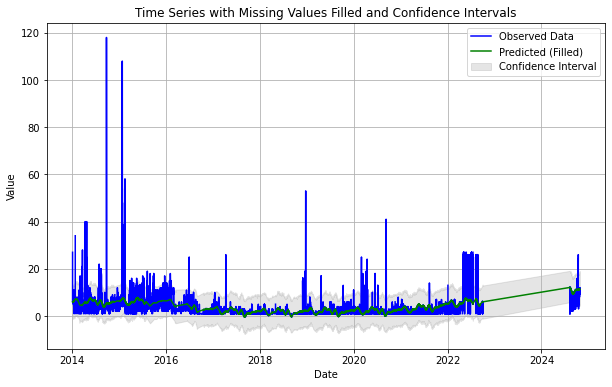

In [10]:
print("\nData after filling missing values recursively:")
print(filled_data.head(10))  # Check the filled data

print("\nForecast with Confidence Intervals:")
print(forcaste_with_confidence.head(10))  # Check forecast with confidence intervals

# Plot the filled data along with the forecast and confidence intervals
plt.figure(figsize=(10, 6))

# Plot the observed data
plt.plot(filled_data['ds'], filled_data['y'], label='Observed Data', color='blue')
if not forcaste_with_confidence.empty:
    plt.plot(forcaste_with_confidence['ds'], forcaste_with_confidence['yhat'], label='Predicted (Filled)', color='green')
    plt.fill_between(forcaste_with_confidence['ds'], forcaste_with_confidence['yhat_lower'], forcaste_with_confidence['yhat_upper'], color='gray', alpha=0.2, label='Confidence Interval')
    
    # Add labels and title
    plt.title('Time Series with Missing Values Filled and Confidence Intervals')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    
    # Show the plot
    plt.show()

**Filling the missing values here with confidence the data is so sparse that model is predicting negative values that is the best we can do**

In [23]:
filled_data, forcaste_with_confidence=imp_.prohet_imputer(name='pm10')

Data with missing values:
          ds   y
0 2024-10-01 NaN
1 2024-10-02 NaN
2 2024-10-03 NaN
3 2024-10-04 NaN
4 2024-10-05 NaN
5 2024-10-06 NaN
6 2024-10-07 NaN
7 2024-10-08 NaN
8 2024-10-09 NaN
9 2024-10-10 NaN
Found 2064 missing values in 'y' column.


20:57:35 - cmdstanpy - INFO - Chain [1] start processing
20:57:40 - cmdstanpy - INFO - Chain [1] done processing


Forecast structure (first few rows):
          ds       yhat  yhat_lower  yhat_upper
0 2014-01-02  68.481276   46.659802   89.965197
1 2014-01-03  67.714859   44.671651   87.867290
2 2014-01-06  68.179188   46.233658   90.749658
3 2014-01-07  67.990625   47.873311   88.802582
4 2014-01-08  67.883245   47.109483   88.705291
Processing missing value for index 5958
Processing missing value for index 13001
Processing missing value for index 2829
Processing missing value for index 5959
Processing missing value for index 13002
Processing missing value for index 13003
Processing missing value for index 13004
Processing missing value for index 13005
Processing missing value for index 13006
Processing missing value for index 13007
Processing missing value for index 13008
Processing missing value for index 5960
Processing missing value for index 13009
Processing missing value for index 5961
Processing missing value for index 5962
Processing missing value for index 13010
Processing missing value 

Processing missing value for index 9267
Processing missing value for index 9268
Processing missing value for index 9269
Processing missing value for index 9270
Processing missing value for index 2842
Processing missing value for index 9271
Processing missing value for index 2843
Processing missing value for index 9272
Processing missing value for index 12969
Processing missing value for index 2835
Processing missing value for index 2836
Processing missing value for index 9242
Processing missing value for index 9243
Processing missing value for index 9244
Processing missing value for index 9245
Processing missing value for index 9246
Processing missing value for index 9247
Processing missing value for index 2837
Processing missing value for index 9248
Processing missing value for index 9249
Processing missing value for index 9250
Processing missing value for index 9251
Processing missing value for index 2844
Processing missing value for index 9252
Processing missing value for index 9253

Processing missing value for index 750
Processing missing value for index 751
Processing missing value for index 752
Processing missing value for index 753
Processing missing value for index 754
Processing missing value for index 755
Processing missing value for index 756
Processing missing value for index 575
Processing missing value for index 576
Processing missing value for index 577
Processing missing value for index 578
Processing missing value for index 579
Processing missing value for index 580
Processing missing value for index 581
Processing missing value for index 582
Processing missing value for index 583
Processing missing value for index 584
Processing missing value for index 585
Processing missing value for index 586
Processing missing value for index 587
Processing missing value for index 588
Processing missing value for index 589
Processing missing value for index 590
Processing missing value for index 591
Processing missing value for index 592
Processing missing value 

Processing missing value for index 3240
Processing missing value for index 411
Processing missing value for index 9690
Processing missing value for index 3241
Processing missing value for index 3242
Processing missing value for index 412
Processing missing value for index 9691
Processing missing value for index 9692
Processing missing value for index 3243
Processing missing value for index 413
Processing missing value for index 9693
Processing missing value for index 3244
Processing missing value for index 414
Processing missing value for index 415
Processing missing value for index 3245
Processing missing value for index 9694
Processing missing value for index 3246
Processing missing value for index 9695
Processing missing value for index 416
Processing missing value for index 3247
Processing missing value for index 9696
Processing missing value for index 417
Processing missing value for index 418
Processing missing value for index 9697
Processing missing value for index 3248
Processi

Processing missing value for index 308
Processing missing value for index 9588
Processing missing value for index 3140
Processing missing value for index 309
Processing missing value for index 3141
Processing missing value for index 310
Processing missing value for index 9589
Processing missing value for index 311
Processing missing value for index 3142
Processing missing value for index 9590
Processing missing value for index 9591
Processing missing value for index 3143
Processing missing value for index 312
Processing missing value for index 3144
Processing missing value for index 313
Processing missing value for index 9592
Processing missing value for index 3145
Processing missing value for index 314
Processing missing value for index 9593
Processing missing value for index 315
Processing missing value for index 3146
Processing missing value for index 9594
Processing missing value for index 316
Processing missing value for index 3147
Processing missing value for index 9595
Processin

Processing missing value for index 9660
Processing missing value for index 382
Processing missing value for index 3212
Processing missing value for index 9661
Processing missing value for index 383
Processing missing value for index 3213
Processing missing value for index 9662
Processing missing value for index 3214
Processing missing value for index 384
Processing missing value for index 9663
Processing missing value for index 9664
Processing missing value for index 385
Processing missing value for index 3215
Processing missing value for index 9665
Processing missing value for index 386
Processing missing value for index 3216
Processing missing value for index 9666
Processing missing value for index 3217
Processing missing value for index 387
Processing missing value for index 9667
Processing missing value for index 388
Processing missing value for index 3218
Processing missing value for index 389
Processing missing value for index 3219
Processing missing value for index 9668
Processi

Processing missing value for index 9549
Processing missing value for index 271
Processing missing value for index 9550
Processing missing value for index 3102
Processing missing value for index 9551
Processing missing value for index 272
Processing missing value for index 3103
Processing missing value for index 3104
Processing missing value for index 273
Processing missing value for index 9552
Processing missing value for index 274
Processing missing value for index 9553
Processing missing value for index 3105
Processing missing value for index 9554
Processing missing value for index 275
Processing missing value for index 3106
Processing missing value for index 276
Processing missing value for index 9555
Processing missing value for index 3107
Processing missing value for index 9556
Processing missing value for index 3108
Processing missing value for index 277
Processing missing value for index 3109
Processing missing value for index 9557
Processing missing value for index 278
Processi

Processing missing value for index 204
Processing missing value for index 3035
Processing missing value for index 9483
Processing missing value for index 205
Processing missing value for index 3036
Processing missing value for index 9484
Processing missing value for index 206
Processing missing value for index 9485
Processing missing value for index 3037
Processing missing value for index 207
Processing missing value for index 9486
Processing missing value for index 3038
Processing missing value for index 3039
Processing missing value for index 9487
Processing missing value for index 208
Processing missing value for index 26
Processing missing value for index 2857
Processing missing value for index 9307
Processing missing value for index 27
Processing missing value for index 2858
Processing missing value for index 9308
Processing missing value for index 2859
Processing missing value for index 9309
Processing missing value for index 28
Processing missing value for index 2860
Processing 

Processing missing value for index 2924
Processing missing value for index 93
Processing missing value for index 9375
Processing missing value for index 94
Processing missing value for index 2925
Processing missing value for index 95
Processing missing value for index 9376
Processing missing value for index 2926
Processing missing value for index 96
Processing missing value for index 2927
Processing missing value for index 9377
Processing missing value for index 9378
Processing missing value for index 97
Processing missing value for index 2928
Processing missing value for index 2929
Processing missing value for index 98
Processing missing value for index 9379
Processing missing value for index 99
Processing missing value for index 2930
Processing missing value for index 9380
Processing missing value for index 100
Processing missing value for index 9381
Processing missing value for index 2931
Processing missing value for index 2932
Processing missing value for index 9382
Processing miss


Data after filling missing values recursively:
              ds           y
5958  2014-01-01         NaN
5873  2014-01-02   84.000000
13001 2014-01-02   68.481276
2829  2014-01-03   67.714859
5874  2014-01-03  111.000000
5959  2014-01-05         NaN
2726  2014-01-06   77.000000
5875  2014-01-06   78.000000
13002 2014-01-06   68.179188
2727  2014-01-07   91.000000

Forecast with Confidence Intervals:
          ds       yhat  yhat_lower  yhat_upper
0 2014-01-02  68.481276   46.659802   89.965197
1 2014-01-03  67.714859   44.671651   87.867290
2 2014-01-06  68.179188   46.233658   90.749658
3 2014-01-10  67.354349   46.467990   88.117412
4 2014-01-11  65.291380   43.666505   86.784676
5 2014-01-14  69.237228   46.766160   89.694072
6 2014-01-15  69.383747   47.765729   91.988491
7 2014-01-16  69.303091   47.668669   89.721287
8 2014-01-17  69.136209   48.732686   88.715899
9 2014-01-20  70.711907   47.696740   90.689568


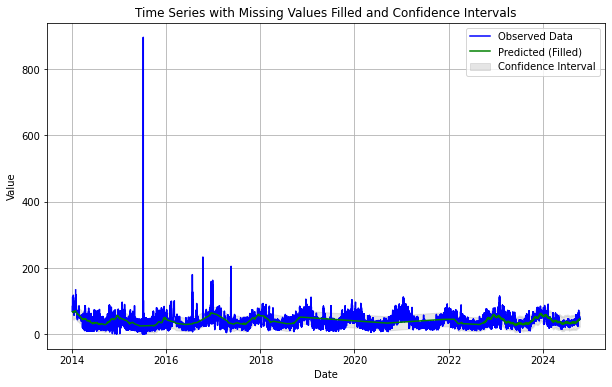

In [24]:
print("\nData after filling missing values recursively:")
print(filled_data.head(10))  # Check the filled data

print("\nForecast with Confidence Intervals:")
print(forcaste_with_confidence.head(10))  # Check forecast with confidence intervals

# Plot the filled data along with the forecast and confidence intervals
plt.figure(figsize=(10, 6))

# Plot the observed data
plt.plot(filled_data['ds'], filled_data['y'], label='Observed Data', color='blue')
if not forcaste_with_confidence.empty:
    plt.plot(forcaste_with_confidence['ds'], forcaste_with_confidence['yhat'], label='Predicted (Filled)', color='green')
    plt.fill_between(forcaste_with_confidence['ds'], forcaste_with_confidence['yhat_lower'], forcaste_with_confidence['yhat_upper'], color='gray', alpha=0.2, label='Confidence Interval')
    
    # Add labels and title
    plt.title('Time Series with Missing Values Filled and Confidence Intervals')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    
    # Show the plot
    plt.show()

* bulding xboost model
* working on imbalance problem 
* working of random forest, scarf (contrastive learning)

In [6]:
#use this object throught out the  feature extraction and mergeing
fea_obj =feature_extraction.features(pre_obj, train_, misc_obj, 
                traffic_path='/home/qb/ML_Group_Assignment/traffic_base.csv', 
                                     rain_path='/home/qb/ML_Group_Assignment/rain_base.csv', traffic =True, rain=True)


In [7]:
x_=fea_obj.traffic_features(phi=3)

<Axes: xlabel='event_count', ylabel='so2'>

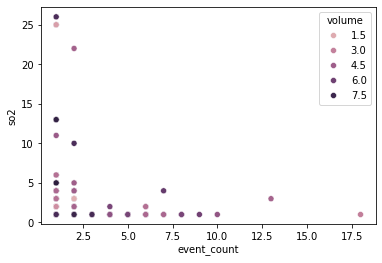

In [15]:
import seaborn as sns
sns.scatterplot(data = x_, x = 'event_count', y = 'so2', hue = 'volume')

**Thses events have spacial relationship too, as we have one event the pm25 might vary 

In [8]:
#add rain features
x_=fea_obj.rain_features(phi=3)

<Axes: xlabel='r_count', ylabel='pm25'>

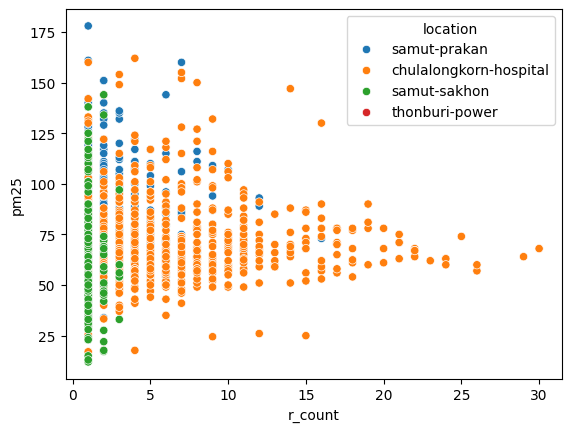

In [49]:
import seaborn as sns
sns.scatterplot(data = x_[x_['pm25'] < 200], x = 'r_count', y = 'pm25', hue='location')
# x_.set_index('date').sort_index()['r_count'].plot()


**rcount is the rain event the 0 means no rain 5 mean 5 times rain in year and month for particular location , now the more we see 0 event count is the more the variation in pm25 , the more the rain event count the pm25 saturates**

In [9]:
#add misc features
fea_obj.mics_features()
#add weather features
fea_obj.weighted_distance()

In [10]:
#add temporal features
x_t=fea_obj.temporal_features()

In [11]:
x_ = pd.read_csv('/home/qb/ML_Group_Assignment/sub_stations/df.csv')

In [239]:
y_h=x_['pm25'].apply(lambda x:convert_aqi_to_category(fea_obj.pm25_to_aqi(x)))

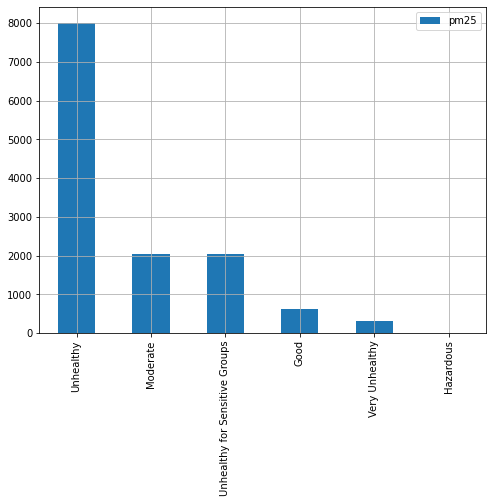

In [100]:
plt.figure(figsize=(8, 6))
y_h.value_counts().plot(kind='bar')
plt.legend()
plt.grid(True)

**Imabalance classes, as per the time constraints, just building a boosting model now that handels imbalance classes with weights**

In [240]:
y_h.value_counts()

Unhealthy                         8013
Moderate                          2047
Unhealthy for Sensitive Groups    2046
Good                               615
Very Unhealthy                     308
Name: pm25, dtype: int64

**will skil the hazadious class of sample unless we collate the data and imporve our model more**

In [241]:
#label encode as it is no issue of dataleakage just label encode before the split 
le = LabelEncoder()
x_['location']=le.fit_transform(x_['location'])
# x_.drop(columns = ['Unnamed: 0.1', 'Unnamed: 0', 'index', 'date'], inplace=True)

In [242]:
#label encode the target variable
# y_h=np.delete(y_h,np.where(y_h == None)[0])

de_le = LabelEncoder()
y=pd.Series(de_le.fit_transform(y_h))

In [114]:
#we are trining boosting model so scaling is not much of issue
x_.head()

,location,year,month,day,pm25,pm10,o3,no2,so2,co,...,w_wind_speed,temp_avg,y_lag_1,y_lag_2,y_lag_3,y_lag_4,y_lag_5,y_lag_6,y_lag_7,wom
0,1,2024,10,1,72.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,1,2024,10,2,65.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,72.0,NaN,NaN,NaN,NaN,NaN,NaN,0
2,1,2024,10,3,70.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,65.0,72.0,NaN,NaN,NaN,NaN,NaN,0
3,1,2024,10,4,70.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,70.0,65.0,72.0,NaN,NaN,NaN,NaN,0
4,1,2024,10,5,93.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,70.0,70.0,65.0,72.0,NaN,NaN,NaN,0


In [274]:
np.random.seed(42)
train, test, x_target, y_target=train_test_split(x_, y, test_size=0.2, random_state=42, shuffle=False)

In [280]:
def fit_and_score(estimator, X_train, X_test, y_train, y_test, weights):
    """Fit the estimator on the train set and score it on both sets"""
    estimator.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=True
                 ,sample_weight = weights)
    
    train_score = estimator.score(X_train, y_train)
    test_score = estimator.score(X_test, y_test)

    return estimator, train_score, test_score


cv = StratifiedKFold(n_splits=3, shuffle=False)
# cv = LeaveOneOut()
#fix these parameter
params = {'max_depth':3, 'eta':0.01, 'eval_metric': 'mlogloss',  # Correct metric for multi-class classification
          'colsample_bytree':0.5,'enable_categorical':True, 'lambda':0.1}
evallist = [(train, 'train'), (test, 'eval')]
reg = xgb.XGBClassifier(early_stopping_rounds=3,  **params, objective='multi:softprob',num_class=5)

results = {'train_res':[], 'test_res':[]}

for train_index, test_index in cv.split(train, x_target):
    X_train = train.loc[train_index]
    X_test = train.loc[test_index]
    y_train = x_target.loc[train_index]
    y_test = x_target.loc[test_index]
    sample_weights = compute_sample_weight('balanced', y_train)
    est, train_score, test_score = fit_and_score(
        reg, X_train, X_test, y_train, y_test,
    weights = sample_weights)
    results['train_res'].append(train_score)
    results['test_res'].append(test_score)

    
    
#write the testing functions
#perform testing 

[0]	validation_0-mlogloss:1.58873
[1]	validation_0-mlogloss:1.56453
[2]	validation_0-mlogloss:1.54459
[3]	validation_0-mlogloss:1.53162
[4]	validation_0-mlogloss:1.51653
[5]	validation_0-mlogloss:1.50588
[6]	validation_0-mlogloss:1.48975
[7]	validation_0-mlogloss:1.47132
[8]	validation_0-mlogloss:1.45541
[9]	validation_0-mlogloss:1.43431
[10]	validation_0-mlogloss:1.42201
[11]	validation_0-mlogloss:1.41405
[12]	validation_0-mlogloss:1.39651
[13]	validation_0-mlogloss:1.38567
[14]	validation_0-mlogloss:1.36810
[15]	validation_0-mlogloss:1.35732
[16]	validation_0-mlogloss:1.34646
[17]	validation_0-mlogloss:1.33819
[18]	validation_0-mlogloss:1.32702
[19]	validation_0-mlogloss:1.31176
[20]	validation_0-mlogloss:1.30121
[21]	validation_0-mlogloss:1.28429
[22]	validation_0-mlogloss:1.27182
[23]	validation_0-mlogloss:1.26341
[24]	validation_0-mlogloss:1.24762
[25]	validation_0-mlogloss:1.23163
[26]	validation_0-mlogloss:1.22482
[27]	validation_0-mlogloss:1.21138
[28]	validation_0-mlogloss:1.1

[35]	validation_0-mlogloss:1.21030
[36]	validation_0-mlogloss:1.20631
[37]	validation_0-mlogloss:1.20372
[38]	validation_0-mlogloss:1.20134
[39]	validation_0-mlogloss:1.19725
[40]	validation_0-mlogloss:1.18682
[41]	validation_0-mlogloss:1.17561
[42]	validation_0-mlogloss:1.16208
[43]	validation_0-mlogloss:1.15847
[44]	validation_0-mlogloss:1.15474
[45]	validation_0-mlogloss:1.14966
[46]	validation_0-mlogloss:1.13848
[47]	validation_0-mlogloss:1.12777
[48]	validation_0-mlogloss:1.12614
[49]	validation_0-mlogloss:1.12201
[50]	validation_0-mlogloss:1.11373
[51]	validation_0-mlogloss:1.10452
[52]	validation_0-mlogloss:1.09977
[53]	validation_0-mlogloss:1.08631
[54]	validation_0-mlogloss:1.08027
[55]	validation_0-mlogloss:1.06855
[56]	validation_0-mlogloss:1.05916
[57]	validation_0-mlogloss:1.05056
[58]	validation_0-mlogloss:1.04534
[59]	validation_0-mlogloss:1.03485
[60]	validation_0-mlogloss:1.02924
[61]	validation_0-mlogloss:1.01968
[62]	validation_0-mlogloss:1.01022
[63]	validation_0-ml

In [171]:
# sample_weights = compute_sample_weight('balanced',y_target)
# sample_weights.shape
# idx = np.where(y==5)
# y=pd.Series(np.delete(y.values, idx[0]))
# x_=x_.drop(5167)
# y.reset_index(drop = True, inplace=True )
# x_.reset_index(drop = True, inplace =True)

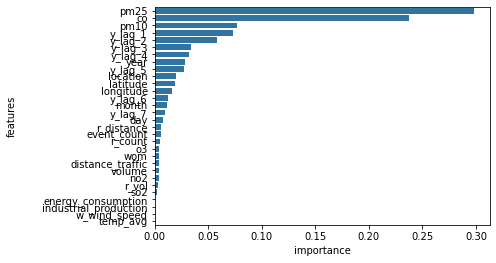

In [303]:
fp = pd.DataFrame({'importance':reg.feature_importances_, 'features':reg.feature_names_in_})
ax=sns.barplot(data = fp.sort_values('importance', ascending=False), x = 'importance', y = 'features')
ax.yaxis.labelpad = 25 # Adjust the padding (in points)
plt.show()

In [320]:
def cross_entropy_loss(y_true, y_pred):
    epsilon = 1e-15
    y_pred = np.clip(y_pred, epsilon, 1. - epsilon)
    loss = -np.sum(y_true * np.log(y_pred)) / y_true.shape[0]
    
    return loss

scores = dict({'accuracy_score':[], 'recall_score':[], 'precision_score':[], 'corss_entropy':[]})
predict=reg.predict(test)
scores['accuracy_score'].append(accuracy_score(y_target , predict))
scores['recall_score'].append(recall_score(y_target, predict, average='macro'))
scores['precision_score'].append(precision_score(y_target, predict, average='macro'))
scores['corss_entropy'].append(cross_entropy_loss(y_target, predict))
pd.DataFrame(scores, index=pd.Index(['Xgb'], name = 'Scores')).style 

,accuracy_score,recall_score,precision_score,corss_entropy
Scores,,,,
Xgb,0.961243,0.945199,0.943603,0.609664


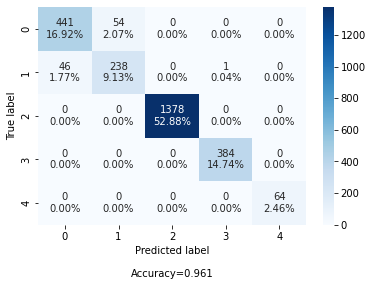

In [325]:
make_confusion_matrix(confusion_matrix(y_target, predict))

In [335]:
import pickle
with open('xgb_model', "wb") as fp:
    pickle.dump(reg, fp)

**The model is overfitting and because we have shorter sample of data once again collate the data and run everything**